In [1]:
%load_ext autoreload
%autoreload 2

### Data setup

In [45]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from prod.engine_utils import * 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder

def cohort_grouper(df, group_key='cohort_date', 
                   target_variables=['active_users_users'],\
                   group_statics=['dx'], 
                   group_freq='W', group_function=np.sum):
    return df.groupby([pd.Grouper(key=group_key, freq=group_freq)] + group_statics)[target_variables]\
             .agg(group_function)\
             .reset_index()

def remove_nans_from_array(y):
    return y[~np.isnan(y)]

def count_nons_nans_in_array(y):
    return np.count_nonzero(~np.isnan(y))

def nan_padding(x, target_length):
    # padding sequences with nans in order to speed up computation with batches
    # use with caution and propagating nans
    return x + [np.nan] * (target_length - len(x))

def init_nans(shapes):
    x = np.zeros(shapes)
    x[:] = np.nan
    return x


class FeatureEngineeringTransformer(TransformerMixin, BaseEstimator):
    """Feature Engineering transform class for ML inputs"""

    def __init__(self):
        self.encoding_variables = {}

    def fit_transform(self, df):
        """ Fit-transform function applied to training (input) domain
        """
        
        self.encoding_variables['ohe_col_names'] = []
        if "country" in df:
            ohe_country_encoder = OneHotEncoder(sparse=False)
            encoded_array = ohe_country_encoder.fit_transform(
                df.loc[:, ["country"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=ohe_country_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)

            self.ohe_country_encoder = ohe_country_encoder
            self.encoding_variables['ohe_col_names'] += list(ohe_country_encoder.get_feature_names_out())

        if "channel" in df:
            ohe_channel_encoder = OneHotEncoder(sparse=False)
            encoded_array = ohe_channel_encoder.fit_transform(
                df.loc[:, ["channel"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=ohe_channel_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)
            self.ohe_channel_encoder = ohe_channel_encoder

            self.encoding_variables['ohe_col_names'] += list(ohe_channel_encoder.get_feature_names_out()) 

        if "platform" in df:
            ohe_platform_encoder = OneHotEncoder(sparse=False)
            encoded_array = ohe_platform_encoder.fit_transform(
                df.loc[:, ["platform"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=ohe_platform_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)
            self.ohe_platform_encoder = ohe_platform_encoder

            self.encoding_variables['ohe_col_names'] += list(ohe_platform_encoder.get_feature_names_out()) 

        return df
    

    def transform(self, df):
        """Feature transform function for forecast and extrapolate domain
        """
        if "country" in df:
            encoded_array = self.ohe_country_encoder.transform(
                df.loc[:, ["country"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=self.ohe_country_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)

        if "channel" in df:
            encoded_array = self.ohe_channel_encoder.transform(
                df.loc[:, ["channel"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=self.ohe_channel_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)

        if "platform" in df:
            encoded_array = self.ohe_platform_encoder.transform(
                df.loc[:, ["platform"]]
            )
            df_encoded = pd.DataFrame(
                encoded_array, columns=self.ohe_platform_encoder.get_feature_names_out()
            )
            df = pd.concat([df, df_encoded], axis=1)

        return df


class RetNormalizer(TransformerMixin, BaseEstimator):
    
    def __init__(self):
        self.encoding_variables = {}
    
    def _fit_transform_normalize_retention(self, df):
        MAX_DX = 90

        df['active_users'] = df['retention'] * df['cohort_size']
        df['sq_au'] = df['active_users']**2

        std_retention_df = np.sqrt(df[df['dx'] < MAX_DX].groupby('dx')['sq_au'].sum() / df[df['dx'] < MAX_DX].groupby('dx')['cohort_size'].sum())
        avg_retention_df = (df[df['dx'] < MAX_DX].groupby('dx')['active_users'].sum() / df[df['dx'] < MAX_DX].groupby('dx')['cohort_size'].sum())

        self.encoding_variables["std_retention_df"] = std_retention_df
        self.encoding_variables["avg_retention_df"] = avg_retention_df

        df = (
            pd.merge(df, std_retention_df.rename("std_retention"), left_on='dx', right_index=True)
            .fillna({"std_retention": std_retention_df.values[-1]})
            .merge(avg_retention_df.rename("avg_retention"), left_on='dx', right_index=True)
            .fillna({"avg_retention": avg_retention_df.values[-1]})
            .eval("norm_retention = (retention - avg_retention) / std_retention")
        ) 

        return df.drop(["sq_au","std_retention","avg_retention"], axis=1)


    def _transform_normalize_retention(self, df):
        std_retention_df = self.encoding_variables["std_retention_df"]
        avg_retention_df = self.encoding_variables["avg_retention_df"]

        df = (
            pd.merge(df, std_retention_df.rename("std_retention"), left_on='dx', right_index=True)
            .fillna({"std_retention": std_retention_df.values[-1]})
            .merge(avg_retention_df.rename("avg_retention"), left_on='dx', right_index=True)
            .fillna({"avg_retention": avg_retention_df.values[-1]})
            .eval("norm_retention = (retention - avg_retention) / std_retention")
        )

        return df.drop(["std_retention","avg_retention"], axis=1)


    def get_retention_values(self, df):
        std_retention_df = self.encoding_variables["std_retention_df"]
        avg_retention_df = self.encoding_variables["avg_retention_df"]

        df = (
            pd.merge(df, std_retention_df.rename("std_retention"), left_on='dx', right_index=True)
            .fillna({"std_retention": std_retention_df.values[-1]})
            .merge(avg_retention_df.rename("avg_retention"), left_on='dx', right_index=True)
            .fillna({"avg_retention": avg_retention_df.values[-1]})
            .eval("pred_retention = ypred * std_retention + avg_retention")
        )

        return df.drop(["std_retention","avg_retention"], axis=1)

In [46]:
filename ='clf_data/clf_sparse_retention_dataset.parquet'#clf_parquet_thomas_sample_cohortised_aprdau.parquet'#
raw_data = pd.read_parquet(filename)

#.query("country=='US' and platform=='ANDROID' and channel=='organic'")\#
#.pipe(cohort_grouper, target_variables=['active_users'])\
segment_data = raw_data\
.dropna()\
.pipe(calculate_days_since_install)\
.pipe(format_date_column, column='cohort_date')\
.pipe(calculate_activity_date)
segment_data['dx']=segment_data['dx'].astype(int)

In [47]:
start_date, end_date = pd.to_datetime('2020-06-01'), pd.to_datetime('2022-01-01')
full_dataset = pd.DataFrame()
full_domain_dimensions = generate_ranged_clf_dataframe(
                start_date=start_date,
                end_date=end_date
)


for pl, ch, co in segment_data[['platform','channel','country']].drop_duplicates().values:
    _segment = (
        segment_data
        .query("country==@co and platform==@pl and channel==@ch")
        .merge(full_domain_dimensions[['cohort_date','dx']], how='right')
        .eval("country = @co").eval("platform = @pl").eval("channel = @ch")
    )
    full_dataset = pd.concat((full_dataset, _segment))

In [48]:
full_dataset = (
    full_dataset
    .pipe(calculate_activity_date)
    .fillna({'active_users': 0})
    .assign(
        cohort_size = lambda df: df.groupby(['platform','channel','country','cohort_date'])['active_users'].transform(max)
    )
)

In [49]:
actual_input = (
    full_dataset
    .assign(retention=lambda x: x['active_users']/x['cohort_size'])
    .fillna({"cohort_size": 0,"retention": 0})
    .pipe(calculate_activity_date)
    .query("dx > 0")
    .query("dx < 300")
    .query("cohort_size > 3")
    .assign(
        day_of_week_sin = lambda df: np.sin(df['calendar_date'].dt.weekday * (2 * np.pi / 7)),
        day_of_week_cos = lambda df: np.cos(df['calendar_date'].dt.weekday * (2 * np.pi / 7)),
        cohort_code = lambda df: (df.cohort_date - df.cohort_date.min()).dt.days,
        norm_cohort_code = lambda df: df.cohort_code / df.cohort_code.max(),
        calendar_code = lambda df: (df.calendar_date - df.calendar_date.min()).dt.days,
        norm_calendar_code = lambda df: df.calendar_code / df.calendar_code.max(),
        log_dnu = lambda df: np.log1p(df['cohort_size']),
        log_dx = lambda df: np.log1p(df['dx']),
        weight = lambda df: np.clip(np.sqrt(df['cohort_size']) / 20.0, 0.2, 1.2),
    )
    .reset_index(drop=True)
)

In [50]:
end_train_date = end_date - pd.Timedelta(90,'D')
train_domain = generate_ranged_clf_dataframe(
            start_date=start_date,
            end_date=end_train_date,
        ).assign(domain = 'train')

In [51]:
training_input = actual_input.merge(train_domain[['cohort_date','dx','domain']], on=['cohort_date','dx'])

In [52]:
fe = FeatureEngineeringTransformer()
training_input = fe.fit_transform(training_input)
features = ["norm_cohort_code", "norm_calendar_code", "log_dnu", "log_dx", "day_of_week_sin", "day_of_week_cos"] + fe.encoding_variables['ohe_col_names']

In [53]:
ret_norm = RetNormalizer()

In [54]:
training_input = ret_norm._fit_transform_normalize_retention(training_input)

In [102]:
# check xgboost version
import xgboost as xgb
from xgboost import XGBRegressor
xgb.set_config(verbosity=1)


In [157]:
model = XGBRegressor(learning_rate = 0.3,
                    n_estimators = 10, # large dataset so we can pump up the number of estimators
                    max_depth = 6,
                    min_child_weight = 1,
                    subsample = 0.7,
                    colsample_bytree = 0.7,
                    objective="reg:squarederror",#squared_log,#
                    n_jobs = 2,
                    verbosity = 1,
                    eval_metric=['rmse','logloss'],
                    seed = 13)

In [158]:
X = training_input[features].values
y = training_input['retention'].values#training_input['norm_retention']
dtrain = xgb.DMatrix(X, y)

In [159]:
model.fit(X, y, eval_set=[(X,y)])

[0]	validation_0-rmse:0.24088	validation_0-logloss:0.33468
[1]	validation_0-rmse:0.12746	validation_0-logloss:0.20435
[2]	validation_0-rmse:0.07598	validation_0-logloss:0.15062
[3]	validation_0-rmse:0.05601	validation_0-logloss:0.12810
[4]	validation_0-rmse:0.04971	validation_0-logloss:0.11906
[5]	validation_0-rmse:0.04781	validation_0-logloss:0.11530
[6]	validation_0-rmse:0.04725	validation_0-logloss:0.11391
[7]	validation_0-rmse:0.04711	validation_0-logloss:0.11346
[8]	validation_0-rmse:0.04682	validation_0-logloss:0.11319
[9]	validation_0-rmse:0.04670	validation_0-logloss:0.11326
[10]	validation_0-rmse:0.04666	validation_0-logloss:0.11358
[11]	validation_0-rmse:0.04654	validation_0-logloss:0.11357
[12]	validation_0-rmse:0.04639	validation_0-logloss:0.11368
[13]	validation_0-rmse:0.04635	validation_0-logloss:0.11426
[14]	validation_0-rmse:0.04623	validation_0-logloss:0.11391
[15]	validation_0-rmse:0.04618	validation_0-logloss:0.11398
[16]	validation_0-rmse:0.04613	validation_0-loglos

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=['rmse', 'logloss'],
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.5, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, n_estimators=30, n_jobs=2,
             num_parallel_tree=None, predictor=None, random_state=None, ...)

In [160]:
end_train_date = end_date - pd.Timedelta(90,'D')
forecast_domain = generate_ranged_clf_dataframe(
            start_date=end_train_date + pd.Timedelta(1,'D'),
            end_date=end_date,
        ).assign(domain = 'test')

In [161]:
forecast_input = actual_input.merge(forecast_domain[['cohort_date','dx','domain']], on=['cohort_date','dx'])
forecast_input = fe.transform(forecast_input)
#forecast_input = ret_norm._transform_normalize_retention(forecast_input)

In [168]:
forecast_X, forecast_Y = forecast_input[features], forecast_input['retention'].to_frame()
predicted_Y = model.predict(forecast_X)
forecast_input['ypred'] = predicted_Y
#forecast_input = ret_norm.get_retention_values(forecast_input)

training_predicted_Y = model.predict(X)
training_input['ypred'] = training_predicted_Y

In [169]:
_uao = forecast_input.query("country=='US' and platform=='IOS' and channel=='organic'").copy()
_uao['cohort_date'] = _uao['cohort_date'].dt.date

_train_uao = training_input.query("country=='US' and platform=='IOS' and channel=='organic'").copy()
_train_uao['cohort_date'] = _train_uao['cohort_date'].dt.date

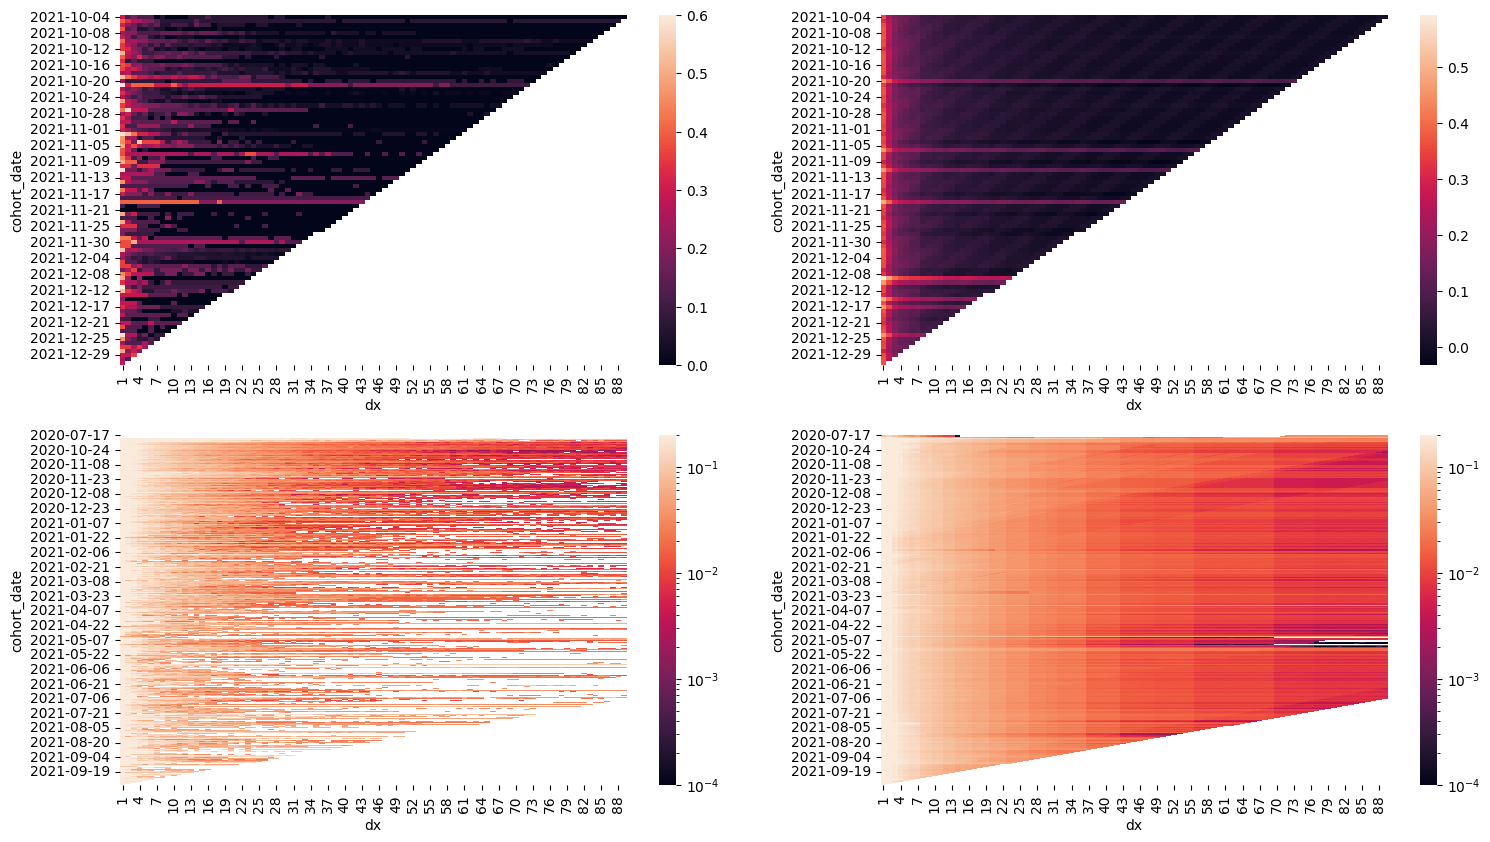

In [174]:
fig, axes = plt.subplots(2,2,figsize=(18,10))
lognorm = LogNorm(vmin=0.0001,vmax=0.2)
sns.heatmap(_uao.pivot(index='cohort_date',columns='dx',values='retention'), ax=axes[0,0]);
sns.heatmap(_uao.pivot(index='cohort_date',columns='dx',values='ypred'), ax=axes[0,1]);

sns.heatmap(_train_uao.pivot(index='cohort_date',columns='dx',values='retention'), ax=axes[1,0], norm=lognorm);
sns.heatmap(_train_uao.pivot(index='cohort_date',columns='dx',values='ypred'), ax=axes[1,1], norm=lognorm);

In [171]:
forecast_input = (
    forecast_input
    .assign(
        actual = lambda df : df['retention'] * df['cohort_size'],
        forecast = lambda df : df['ypred'] * df['cohort_size'],
    )
)

training_input = (
    training_input
    .assign(
        actual = lambda df : df['retention'] * df['cohort_size'],
        forecast = lambda df : df['ypred'] * df['cohort_size'],
    )
)

In [172]:
(forecast_input['forecast'].sum() - forecast_input['actual'].sum()) /  forecast_input['actual'].sum(),\
(training_input['forecast'].sum() - training_input['actual'].sum()) /  training_input['actual'].sum()

(0.40645747610990346, 0.0048776489888238805)

In [106]:
training_input['ypred'] = model.predict(training_input[features])

In [107]:
_uao = training_input.query("country=='US' and platform=='IOS' and channel=='organic'").copy()
_uao['cohort_date'] = _uao['cohort_date'].dt.date

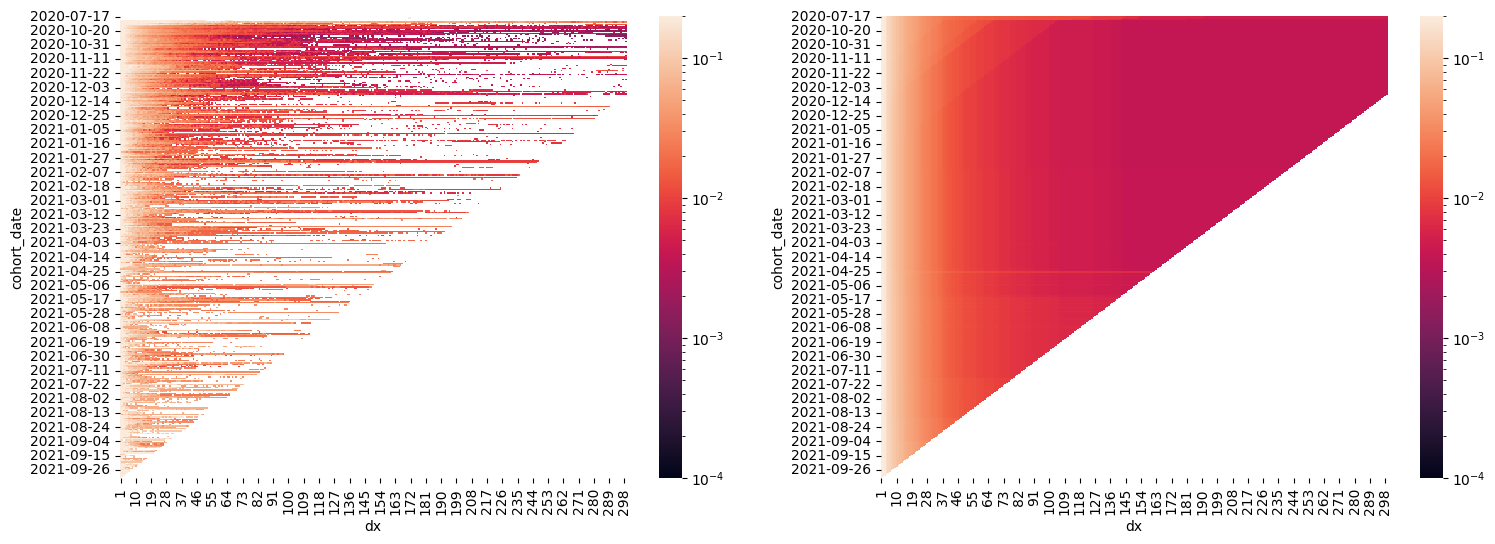

In [108]:
fig, axes = plt.subplots(1,2,figsize=(18,6))
lognorm = LogNorm(vmin=0.0001,vmax=0.2)
sns.heatmap(_uao.pivot(index='cohort_date',columns='dx',values='retention'), norm=lognorm, ax=axes[0]);
sns.heatmap(_uao.pivot(index='cohort_date',columns='dx',values='ypred'), norm=lognorm, ax=axes[1]);